# Question 3

In [10]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/ML_HW5/Q3_winequalityN.csv')
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
df.isna().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
X = df.iloc[:,1:]
y = df['type']

In [8]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance', metric='manhattan', algorithm='ball_tree')

In [9]:
def calculate_score(model, X, y):
    model.fit(X, y)
    return model.score(X, y)

def sfs(model, X, y, k): 
    n_features = X.shape[1] 
    # Initialize the list of indices to include in the model 
    included = [] 

    # Loop until k features are selected 
    while len(included) < k: 

        # Initialize best score and best feature to -1 
        best_score = -1 
        best_feature = -1

        # Loop over all features not already included in the model 
        for i in range(n_features): 

            if i not in included:  

                # Create a new subset of features including i  
                new_included = included + [i]  

                # Calculate score with new subset of features  
                score = calculate_score(model, X.iloc[:, new_included], y)  

                # If score is better than current best, update best score and feature  
                if score > best_score:  
                    best_score = score  
                    best_feature = i  

        # Add the feature with the highest score to the model    
        included.append(best_feature)    

    return included

In [10]:
indeces = sfs(knn, X, y, 2)
sfs_result = list(X.columns[indeces])

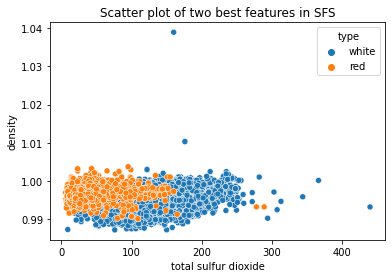

In [12]:
sns.scatterplot(data=df, x=sfs_result[0], y=sfs_result[1], hue="type");
plt.title("Scatter plot of two best features in SFS");

In [17]:
X[sfs_result]
y

0       white
1       white
2       white
3       white
4       white
        ...  
6491      red
6492      red
6494      red
6495      red
6496      red
Name: type, Length: 6463, dtype: object

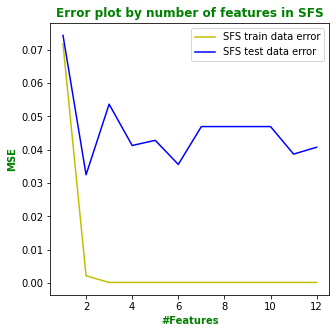

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import time

sfs_err_train = list()
sfs_err_test = list()

n_samples, n_features = X.shape

y_code = pd.factorize(df['type'])[0]

X_train, X_test, y_train, y_test = train_test_split(X, y_code, test_size=0.3)

time_sum = 0

for i in range(n_features):
    knn = KNeighborsClassifier(n_neighbors=10, weights='distance', metric='manhattan', algorithm='ball_tree') 
    init_time = time.time()
    indeces = sfs(knn, X_train, y_train, i+1)
    time_sum += time.time() - init_time
    sfs_result = list(X_train.columns[indeces])
    knn.fit(X_train[sfs_result], y_train)

    y_pred = knn.predict(X_train[sfs_result])
    mse_train = mean_squared_error(y_train, y_pred)
    sfs_err_train.append(mse_train)

    y_pred = knn.predict(X_test[sfs_result])
    mse_test = mean_squared_error(y_test, y_pred)
    sfs_err_test.append(mse_test)
    
plt.figure(figsize = (5, 5)) 
plt.plot([int(i) for i in range(1, n_features+1)], sfs_err_train, color="y", label="SFS train data error")
plt.plot([int(i) for i in range(1, n_features+1)], sfs_err_test, color="b", label="SFS test data error")

plt.title("Error plot by number of features in SFS", color = 'green', fontweight = 'bold') 
plt.xlabel("#Features", color = 'green', fontweight = 'bold') 
plt.ylabel("MSE", color = 'green', fontweight = 'bold')

plt.legend(loc="best")
plt.show()

In [32]:
time_ave_sfs = time_sum / n_features
print(f'Average time for sfs {time_ave_sfs}')

Average time for sfs 2.8563741048177085


In [13]:
#Defining the RFE function 
def RFE(model, X, y, num_features): 

    #Initializing the variables 
    n_samples, n_features = X.shape 
    accuracy_list = [] #list to store accuracy scores of each iteration 

    #Looping over all the features of X 
    for feature in range(n_features):  
        #Creating a copy of X and removing the feature column from it  
        X_subset = X.drop(X.columns[feature], axis = 1)  

        #Fitting a model on the new dataset and calculating its score  
        score = calculate_score(model, X_subset, y) 

        #Appending the score to the list  
        accuracy_list.append(score)  

    #Finding the index of the feature with highest accuracy score    
    index = np.argmax(accuracy_list)    

    #Removing that feature from X    
    X = X.drop(X.columns[index], axis = 1)    

    #Decrementing num_features by 1    
    num_features -= 1    

    #Recursively calling RFE until num_features reaches 0    
    if (num_features > 0):        
        return RFE(model, X, y, num_features)        

    else:        
        return list(X.columns)

In [14]:
rfe_result = RFE(knn, X, y, 10)

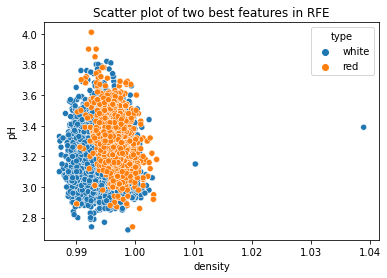

In [15]:
sns.scatterplot(data=df, x=rfe_result[0], y=rfe_result[1], hue="type");
plt.title("Scatter plot of two best features in RFE");

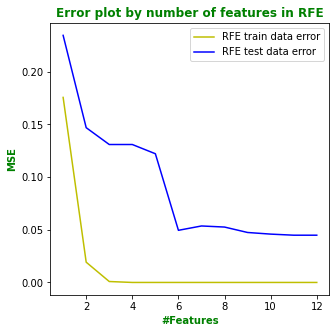

In [33]:
rfe_err_train = list()
rfe_err_test = list()

n_samples, n_features = X.shape

y_code = pd.factorize(df['type'])[0]

X_train, X_test, y_train, y_test = train_test_split(X, y_code, test_size=0.3)

time_sum = 0

for i in range(n_features):
    knn = KNeighborsClassifier(n_neighbors=10, weights='distance', metric='manhattan', algorithm='ball_tree') 
    init_time = time.time()
    rfe_result = RFE(knn, X, y, n_features-i-1)
    time_sum += time.time() - init_time
    knn.fit(X_train[rfe_result], y_train)

    y_pred = knn.predict(X_train[rfe_result])
    mse_train = mean_squared_error(y_train, y_pred)
    rfe_err_train.append(mse_train)

    y_pred = knn.predict(X_test[rfe_result])
    mse_test = mean_squared_error(y_test, y_pred)
    rfe_err_test.append(mse_test)
    
plt.figure(figsize = (5, 5)) 
plt.plot([int(i) for i in range(1, n_features+1)], rfe_err_train, color="y", label="RFE train data error")
plt.plot([int(i) for i in range(1, n_features+1)], rfe_err_test, color="b", label="RFE test data error")

plt.title("Error plot by number of features in RFE", color = 'green', fontweight = 'bold') 
plt.xlabel("#Features", color = 'green', fontweight = 'bold') 
plt.ylabel("MSE", color = 'green', fontweight = 'bold')

plt.legend(loc="best")
plt.show()

In [34]:
time_ave_rfe = time_sum / n_features
print(f'Average time for rfe {time_ave_rfe}')

Average time for rfe 7.497432788213094


# Question 4

In [18]:
import imageio
import os
import matplotlib.pyplot as plt
import numpy as np

number of train data images is 154 and number of features for each image is 65536
number of test data images is 59 and number of features for each image is 65536


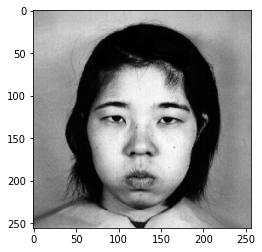

In [19]:
def loadImages(dirName):
    # This function loads images from any directory
    # :param str dirName: is address of the directory (string)

    data = []
    label = []
    for root, dirs, files in os.walk(dirName):
        for file in files:
            face = imageio.imread(os.path.join(root, file)) # Load image from a path
            face = face.reshape(256 * 256, ).tolist()          # Flatten image . Note: size of any image is 256,256
            data.append(face)
            label.append(file.split('.')[1])                   # Label of an image is in its fileName
    return np.asarray(data) , label


train_data , train_label = loadImages('/content/drive/MyDrive/ML_HW5/FACES/train')
test_data , test_label = loadImages('/content/drive/MyDrive/ML_HW5/FACES/test')


print("number of train data images is" , train_data.shape[0] , "and number of features for each image is", train_data.shape[1])
print("number of test data images is" , test_data.shape[0] , "and number of features for each image is", test_data.shape[1])

### To show each images, you should reshape it to 256,256 and then use 'plt.imshow'
plt.imshow(train_data[0].reshape(256,256) , cmap='gray')
plt.show()

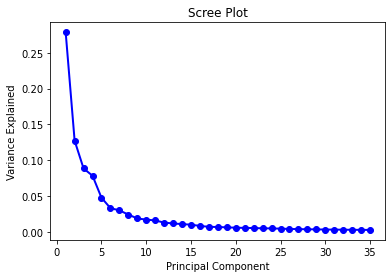

In [20]:
from sklearn.preprocessing import StandardScaler  

#define columns to use for PCA 

df = pd.DataFrame(train_data)

#define scaler 
scaler = StandardScaler() 

#create copy of DataFrame 
scaled_df=df.copy() 

#created scaled version of DataFrame 
scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns) 

from sklearn.decomposition import PCA #define PCA model to use 

pca = PCA(n_components=35) 

#fit PCA model to data 

pca_fit = pca.fit(scaled_df) 

import matplotlib.pyplot as plt 
import numpy as np 

PC_values = np.arange(pca.n_components_) + 1 
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue') 

plt.title('Scree Plot') 
plt.xlabel('Principal Component') 
plt.ylabel('Variance Explained') 
plt.show()


In [21]:
np.unique(train_label)

array(['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise'],
      dtype='<U8')

In [22]:
np.unique(test_label)

array(['disgust', 'fear', 'happy', 'sad', 'surprise'], dtype='<U8')

## KNN for pure data

In [23]:
from sklearn.metrics import confusion_matrix

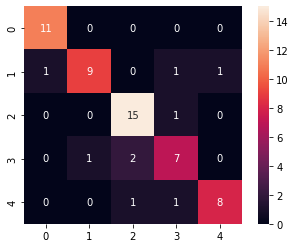

In [24]:
knn1 = KNeighborsClassifier(n_neighbors=1, weights='distance', metric='manhattan', algorithm='ball_tree')
knn1.fit(train_data,train_label)
y_pred1 = knn1.predict(test_data)

confusion_mtx = confusion_matrix(test_label, y_pred1)
sns.heatmap(confusion_mtx, square=True, annot=True, fmt='d', cbar=True);

In [25]:
print(classification_report(test_label, y_pred1))

              precision    recall  f1-score   support

     disgust       0.92      1.00      0.96        11
        fear       0.90      0.75      0.82        12
       happy       0.83      0.94      0.88        16
         sad       0.70      0.70      0.70        10
    surprise       0.89      0.80      0.84        10

    accuracy                           0.85        59
   macro avg       0.85      0.84      0.84        59
weighted avg       0.85      0.85      0.85        59



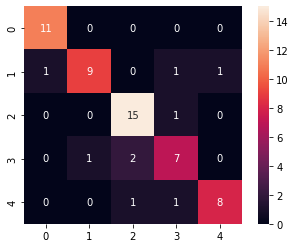

In [26]:
knn2 = KNeighborsClassifier(n_neighbors=2, weights='distance', metric='manhattan', algorithm='ball_tree')
knn2.fit(train_data,train_label)
y_pred2 = knn2.predict(test_data)

confusion_mtx = confusion_matrix(test_label, y_pred2)
sns.heatmap(confusion_mtx, square=True, annot=True, fmt='d', cbar=True);

In [27]:
print(classification_report(test_label, y_pred2))

              precision    recall  f1-score   support

     disgust       0.92      1.00      0.96        11
        fear       0.90      0.75      0.82        12
       happy       0.83      0.94      0.88        16
         sad       0.70      0.70      0.70        10
    surprise       0.89      0.80      0.84        10

    accuracy                           0.85        59
   macro avg       0.85      0.84      0.84        59
weighted avg       0.85      0.85      0.85        59



## PCA

In [33]:
# pca on train data
scaler = StandardScaler() 
train_data_s = scaler.fit_transform(train_data)
pca1 = PCA(n_components=35) 

components_train = pca1.fit_transform(train_data_s) 
X_train_pca = pd.DataFrame(components_train)

# pca on test data
scaler = StandardScaler() 
test_data_s = scaler.fit_transform(test_data)
pca2 = PCA(n_components=35) 

components_test = pca2.fit_transform(test_data_s) 
X_test_pca = pd.DataFrame(components_test)

## KNN on PCA data

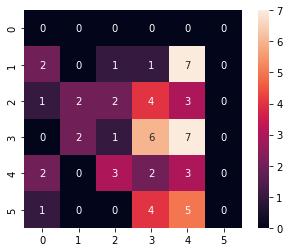

In [34]:
knn_pca1 = KNeighborsClassifier(n_neighbors=1, weights='distance', metric='manhattan', algorithm='ball_tree')
knn_pca1.fit(X_train_pca,train_label)
y_pred1 = knn_pca1.predict(X_test_pca)

confusion_mtx = confusion_matrix(test_label, y_pred1)
sns.heatmap(confusion_mtx, square=True, annot=True, fmt='d', cbar=True);

In [35]:
print(classification_report(test_label, y_pred1))

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00         0
     disgust       0.00      0.00      0.00        11
        fear       0.29      0.17      0.21        12
       happy       0.35      0.38      0.36        16
         sad       0.12      0.30      0.17        10
    surprise       0.00      0.00      0.00        10

    accuracy                           0.19        59
   macro avg       0.13      0.14      0.12        59
weighted avg       0.17      0.19      0.17        59



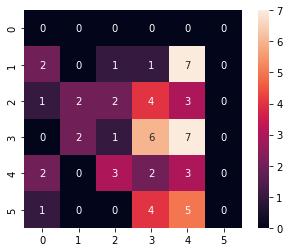

In [36]:
knn_pca2 = KNeighborsClassifier(n_neighbors=2, weights='distance', metric='manhattan', algorithm='ball_tree')
knn_pca2.fit(X_train_pca,train_label)
y_pred2 = knn_pca2.predict(X_test_pca)

confusion_mtx = confusion_matrix(test_label, y_pred2)
sns.heatmap(confusion_mtx, square=True, annot=True, fmt='d', cbar=True);

In [37]:
print(classification_report(test_label, y_pred2))

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00         0
     disgust       0.00      0.00      0.00        11
        fear       0.29      0.17      0.21        12
       happy       0.35      0.38      0.36        16
         sad       0.12      0.30      0.17        10
    surprise       0.00      0.00      0.00        10

    accuracy                           0.19        59
   macro avg       0.13      0.14      0.12        59
weighted avg       0.17      0.19      0.17        59



In [38]:
from sklearn.metrics import accuracy_score
pca_acc = list()

max_components = min(train_data.shape[0], test_data.shape[0])

for i in range(max_components):
    # pca on train data
    pca1 = PCA(n_components=i+1) 
    components_train = pca1.fit_transform(train_data_s) 
    X_train_pca = pd.DataFrame(components_train)

    # pca on test data
    pca2 = PCA(n_components=i+1) 
    components_test = pca2.fit_transform(test_data_s) 
    X_test_pca = pd.DataFrame(components_test)

    #applying knn 
    knn_pca1 = KNeighborsClassifier(n_neighbors=1, weights='distance', metric='manhattan', algorithm='ball_tree')
    knn_pca1.fit(X_train_pca,train_label)
    y_pred1 = knn_pca1.predict(X_test_pca)

    # calculate accuracy
    acc = accuracy_score(test_label, y_pred1)
    pca_acc.append(acc)
    

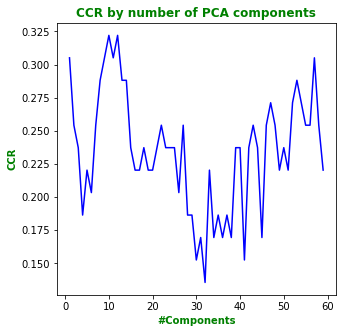

In [40]:
plt.figure(figsize = (5, 5)) 
plt.plot([int(i) for i in range(1, max_components+1)], pca_acc, color="b")

plt.title("CCR by number of PCA components", color = 'green', fontweight = 'bold') 
plt.xlabel("#Components", color = 'green', fontweight = 'bold') 
plt.ylabel("CCR", color = 'green', fontweight = 'bold')

plt.show()

# Question 5

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class LDA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.eig_vectors = None
    
    def transform(self,X,y):
        height, width = X.shape
        unique_classes = np.unique(y)
        num_classes = len(unique_classes)

        scatter_t = np.cov(X.T)*(height - 1)
        scatter_w = 0
        for i in range(num_classes):
            class_items = np.flatnonzero(y == unique_classes[i])
            scatter_w = scatter_w + np.cov(X_train.loc[class_items, :].T) * (len(class_items)-1)
        
        scatter_b = scatter_t - scatter_w
        _, eig_vectors = np.linalg.eigh(np.linalg.pinv(scatter_w).dot(scatter_b))
        pc = X.dot(eig_vectors[:,::-1][:,:self.n_components])
        print(pc.shape)
        
        return pc, scatter_w, scatter_b

In [5]:
X_train = pd.read_csv('/content/drive/MyDrive/ML_HW5/Fashion-MNIST/trainData.csv')
y_train = pd.read_csv('/content/drive/MyDrive/ML_HW5/Fashion-MNIST/trainLabels.csv')
X_test = pd.read_csv('/content/drive/MyDrive/ML_HW5/Fashion-MNIST/testData.csv')
y_test = pd.read_csv('/content/drive/MyDrive/ML_HW5/Fashion-MNIST/testLabels.csv')

In [143]:
LDA_object = LDA()
X_train_modified, scatter_w, scatter_b = LDA_object.transform(X_train, y_train)

print("Original Data Size:",X_train.shape, "\nModified Data Size:", X_train_modified.shape)

(59999, 784)
Original Data Size: (59999, 784) 
Modified Data Size: (59999, 784)


In [144]:
Sep_matrix = np.dot(np.linalg.inv(scatter_w), scatter_b)
eig_values, eig_vectors = np.linalg.eig(Sep_matrix)

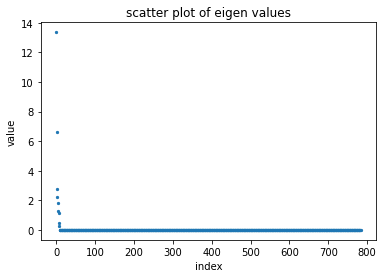

In [145]:
eig_values_sorted = np.sort(eig_values)[::-1]
plt.scatter([int(i) for i in range(eig_values_sorted.shape[0])], eig_values_sorted, s=5)
plt.xlabel('index')
plt.ylabel('value')
plt.title('scatter plot of eigen values')
plt.show()

In [146]:
sep_train = list()
sep_test = list()

n_samples, n_features = X_train.shape

for i in range(n_features):
    LDA_object = LDA(n_components=i+1)
    X_train_modified, scatter_w, scatter_b = LDA_object.transform(X_train, y_train)
    Sep_matrix = np.dot(np.linalg.inv(scatter_w), scatter_b)
    sep_train.append(np.trace(Sep_matrix))

    LDA_object2 = LDA(n_components=i+1)
    X_train_modified2, scatter_w2, scatter_b2 = LDA_object2.transform(X_test, y_test)
    Sep_matrix2 = np.dot(np.linalg.inv(scatter_w2), scatter_b2)
    sep_test.append(np.trace(Sep_matrix2))

(59999, 1)
(9999, 1)
(59999, 2)
(9999, 2)
(59999, 3)
(9999, 3)
(59999, 4)
(9999, 4)
(59999, 5)
(9999, 5)
(59999, 6)
(9999, 6)
(59999, 7)
(9999, 7)
(59999, 8)
(9999, 8)
(59999, 9)
(9999, 9)
(59999, 10)
(9999, 10)
(59999, 11)
(9999, 11)
(59999, 12)
(9999, 12)
(59999, 13)
(9999, 13)
(59999, 14)
(9999, 14)
(59999, 15)
(9999, 15)
(59999, 16)
(9999, 16)
(59999, 17)
(9999, 17)
(59999, 18)
(9999, 18)
(59999, 19)
(9999, 19)
(59999, 20)
(9999, 20)
(59999, 21)
(9999, 21)
(59999, 22)
(9999, 22)
(59999, 23)
(9999, 23)
(59999, 24)
(9999, 24)
(59999, 25)
(9999, 25)
(59999, 26)
(9999, 26)
(59999, 27)
(9999, 27)
(59999, 28)
(9999, 28)
(59999, 29)
(9999, 29)
(59999, 30)
(9999, 30)
(59999, 31)
(9999, 31)
(59999, 32)
(9999, 32)
(59999, 33)
(9999, 33)
(59999, 34)
(9999, 34)
(59999, 35)
(9999, 35)
(59999, 36)
(9999, 36)
(59999, 37)
(9999, 37)
(59999, 38)
(9999, 38)
(59999, 39)
(9999, 39)
(59999, 40)
(9999, 40)
(59999, 41)
(9999, 41)
(59999, 42)
(9999, 42)
(59999, 43)
(9999, 43)
(59999, 44)
(9999, 44)
(59999

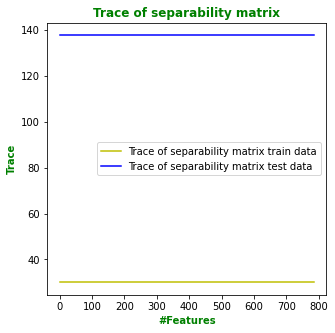

In [137]:
plt.figure(figsize = (5, 5)) 
plt.plot([int(i) for i in range(1, n_features+1)], sep_train, color="y", label="Trace of separability matrix train data")
plt.plot([int(i) for i in range(1, n_features+1)], sep_test, color="b", label="Trace of separability matrix test data")

plt.title("Trace of separability matrix", color = 'green', fontweight = 'bold') 
plt.xlabel("#Features", color = 'green', fontweight = 'bold') 
plt.ylabel("Trace", color = 'green', fontweight = 'bold')

plt.legend(loc="best")
plt.show()

In [6]:
LDA_object1 = LDA(10)
X_train_lda, scatter_w1, scatter_b1 = LDA_object1.transform(X_train, y_train)

LDA_object2 = LDA(10)
X_test_lda, scatter_w2, scatter_b2 = LDA_object2.transform(X_test, y_test)

(59999, 10)
(9999, 10)


### Gaussian Naive Bayes on LDA Data

In [7]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_lda, y_train)
y_pred = gnb.predict(X_test_lda)

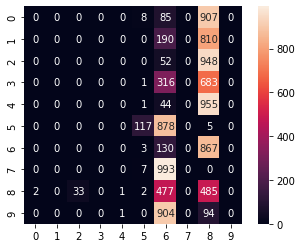

In [9]:
confusion_mtx = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mtx, square=True, annot=True, fmt='d', cbar=True);

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.84      0.12      0.21      1000
           6       0.03      0.13      0.05      1000
           7       0.00      0.00      0.00      1000
           8       0.08      0.48      0.14      1000
           9       0.00      0.00      0.00       999

    accuracy                           0.07      9999
   macro avg       0.10      0.07      0.04      9999
weighted avg       0.10      0.07      0.04      9999



### Gaussian Naive Bayes on Pure Data

In [15]:
gnb1 = GaussianNB()
gnb1.fit(X_train, y_train)
y_pred1 = gnb1.predict(X_test)

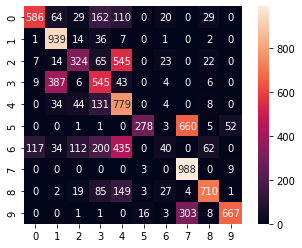

In [16]:
confusion_mtx = confusion_matrix(y_test, y_pred1)
sns.heatmap(confusion_mtx, square=True, annot=True, fmt='d', cbar=True);

In [17]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.81      0.59      0.68      1000
           1       0.64      0.94      0.76      1000
           2       0.59      0.32      0.42      1000
           3       0.44      0.55      0.49      1000
           4       0.38      0.78      0.51      1000
           5       0.93      0.28      0.43      1000
           6       0.32      0.04      0.07      1000
           7       0.51      0.99      0.67      1000
           8       0.83      0.71      0.77      1000
           9       0.91      0.67      0.77       999

    accuracy                           0.59      9999
   macro avg       0.64      0.59      0.56      9999
weighted avg       0.64      0.59      0.56      9999

